<h2> Lab 8

<h3> Exercise Set 1

**(a) Scenario 1**: You have a dataset of 300 documents containing numerical and text records of different nuclear units. Your task is to develop a model that can process similar documents and classify the data based on reactor design (PWR or BWR) and the length of the reactor life (< 40 years, > 40 years but < 60 years, > 60 years).

This is a simply classification problem, although it may be challenging due to a small sample size. I will go with a FNN.

Input layer: All number and text fields from the document are encoded and inputted here. <br>
Dense layers: At least 5, with decreasing nodes from the size of the input layer down to 20 or so. relu activation <br>
Dropout layer: A modest dropout layer would be inserted between the 1st and 2nd dense layer with a dropout rate of 0.1 <br>
Output layer: two outputs, with a softmax activation function.

Loss could be categorical crossentropy with Adam as the optimizer and accuracy as an evaulation metric. I would also utilize k-fold cross validation (k=10) to help make up for the small training size.


**(b) Scenario 2**: You have a dataset of 5000 images of different pipes in a nuclear power plant unit. Your task is to develop a model that can predict the health of similar pipes and classify them into different grades: High, medium, low, or about to break.

This is an image classification problem, so I would use a Convolutional Neural Network. Since the health of the pipe is important rather than the general shape, I would be conservative with pooling, but would add it in as needed due to memory or training limitations using filters of size (2,2) through size (5,5). 

Input layer: shape is (image height, image width, image channels) <br>
Convolutional Layer 1-5: increasing number of filters from 16-128, relu activation <br>
Flattening Layer: to get vector <br>
Dense Layer: Fully connected to all flattened nodes, relu activation <br>
Output Layer: Outputs 4 values for classification (one hot encoded), so softmax activation <br>

Loss could be categorical crossentropy (Since we will one-hot encode our categories) with Adam as the optimizer and Accuracy as an evaluation metric. 

**(c) Scenario 3**: You have a dataset of 100,000 time-dependent measurements of reactor pressure (MPa), fuel temperature (Kelvin), and mass flow rate of coolant (kg/s). Your task is to develop a model that predicts the coolant (water) level in the core in meters as a function of time

We have a large dataset of time-dependent measurements for performing a regression problem. I would utilize a recurrent neural network. Since the dataset is large, I will use an LSTM to control exploding gradients. Since this is not a continuous classification problem, bidirectional LSTM is not needed.

Input layer: size of time series data x 3 (1 for pressure, 1 for temp, 1 for flow) <br>
LSTM layers: three layers of decreasing number of nodes, ending with num_timesteps nodes. Look-back would also be used, starting with look-back=1 <br>
Output layer: A fully-connected dense layer before prediction of size num_timesteps <br>

Loss could be root mean squared error with Adam as the optimizer and RMSE as an evaluation metric as well. 

**(d) Scenario 4**: You have a dataset of static nuclear data (cross-section) measurements taken from a nuclear laboratory for isotopes like U-235, U-238, Pu-239, Pu-240, and other actinides (Am, Cm) and fission products (Cs, Sm). Your task is to develop a model that can predict the value of $ k_{eff} $ based on these cross-section data.

This feels like a trick question. Does $ k_{eff} $ not depend on many factors (like the geometry of the fuel element), of which the cross section is only one? I am not familiar with fission, but it seems like there would be more information required to make a predictive model. If $ k_eff $ is truly determined by material alone, then this is possible. In this case, it would be a simple regression problem, so a FNN should work. 

Input layer: Concentration of each isotope in a paticular fuel. <br>
Dense layers: At least 3, with 25 nodes per layer. relu activation <br>
Dropout layer: A modest dropout layer would be inserted between the 1st and 2nd dense layer with a dropout rate of 0.1 <br>
Output layer: Single output, with a relu activation function for a continuous output 

Loss could be MAE and MAE could be used as an evaluation metric. Adam could be the optimizer. Sorry if I misunderstood this question.




<h3> Exercise Set 2

<h4>----------- Cut File -----------

(a) The correlation matrices of the input data (between the input themselves) and output data
(between the output themselves).
(b) The datafarme that shows the model ranking after tuning.
(c) The diagonal validation plot for an output of your choice (first output by default).
(d) The percent error plot for five outputs of your choice.
(e) The convergence of the Bayesian optimizer for the neural network.
(f) The neural network loss curve for the best neural network model.
(g) Discuss your observations of the performance of the methods and the results you
found.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

In [2]:
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

In [4]:
#load the input and output dataframes from github
xdf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_x.csv')
ydf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_y.csv')

xnames=xdf.columns
ynames=ydf.columns

# Convert np arrays into xarrays
x = xr.DataArray(xdf, name="Input data", dims=["Samples", "Features"], coords={"Features":xnames})
y = xr.DataArray(ydf, name="Target data",dims=["Samples", "Features"], coords={"Features":ynames})

<h3>----------- Cut File -----------

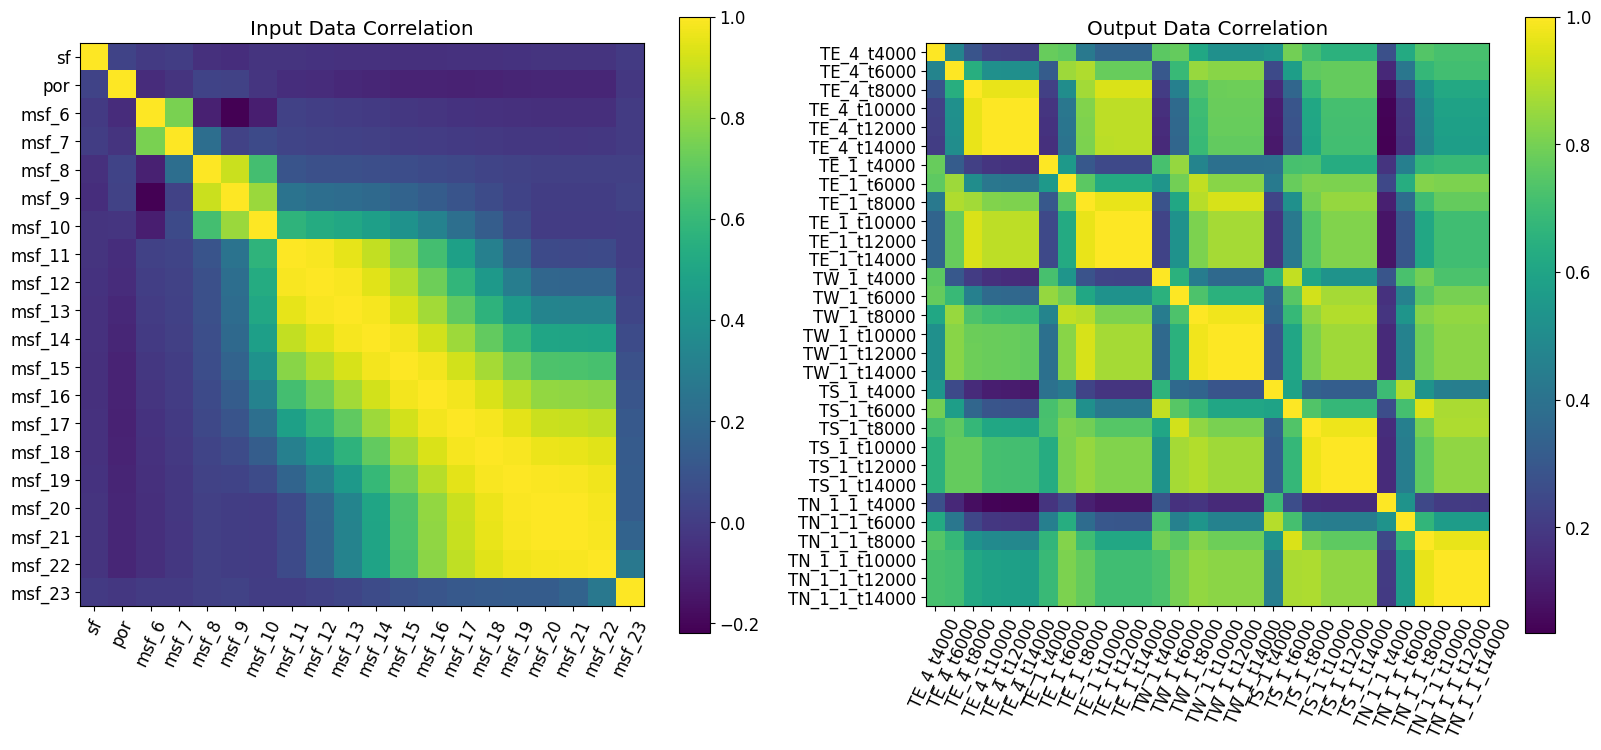

In [5]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("Input Data Correlation")
ax[1].set_title("Output Data Correlation")
correlation_matrix(x, ax=ax[0], fig=fig)
correlation_matrix(y, ax=ax[1], fig=fig)
fig.set_figwidth(20)

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[x, y], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [7]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    #n_iter=3, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    #max_trials=3,
    cv=5,
)


FNN: 100%|██████████| 250/250 [32:54<00:00,  7.90s/it]

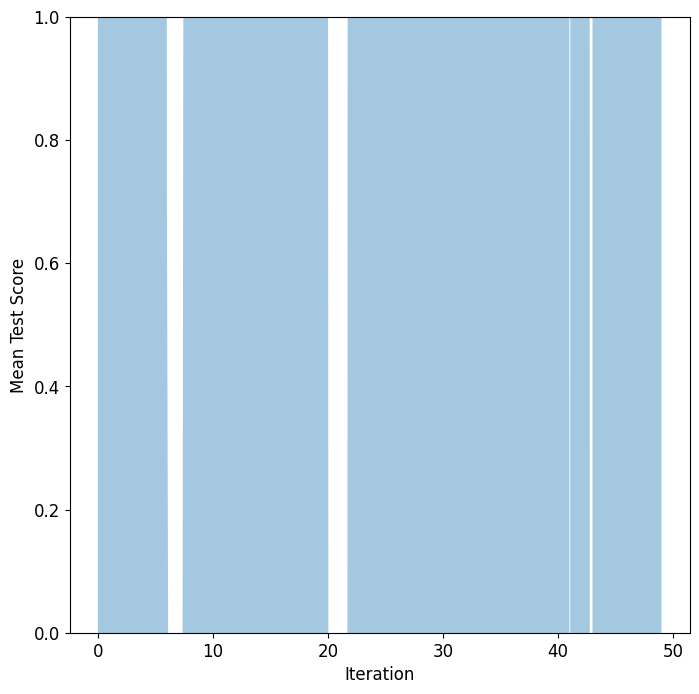

In [8]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

In [9]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 300}},
    },
    yscaler=yscaler,
)

postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
23,FNN,0.984036,7.261432e-01,1.872356e-01,1.436177,2.991675e-01,0.986248,0.914042,0.234494,1.786139,0.363875
22,FNN,0.982119,7.666999e-01,1.922962e-01,1.266677,2.653160e-01,0.985067,0.942090,0.236357,1.619004,0.337546
21,FNN,0.977017,7.447599e-01,1.857333e-01,1.315703,2.731550e-01,0.979834,0.908273,0.226713,1.598446,0.334244
24,FNN,0.968901,1.166875e+00,2.985622e-01,2.236285,4.810726e-01,0.972661,1.295293,0.326842,2.331589,0.463541
25,FNN,0.967271,1.223596e+00,3.224956e-01,2.379360,5.100938e-01,0.970192,1.302322,0.336039,2.474503,0.487393
11,RF,0.938959,3.325202e+00,8.394322e-01,5.862515,1.258316e+00,0.865065,5.212274,1.311026,9.389571,1.936496
13,RF,0.941579,3.559251e+00,9.135349e-01,6.269456,1.335117e+00,0.864758,5.773344,1.465060,10.281490,2.088639
16,KN,1.000000,8.205240e-07,2.060559e-07,0.000003,5.942486e-07,0.863952,5.777649,1.449207,10.499780,2.099879
12,RF,0.942124,3.232997e+00,8.160612e-01,5.696801,1.225318e+00,0.862417,5.261206,1.323998,9.531602,1.955765
17,KN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.861511,5.864660,1.476194,10.607590,2.137650


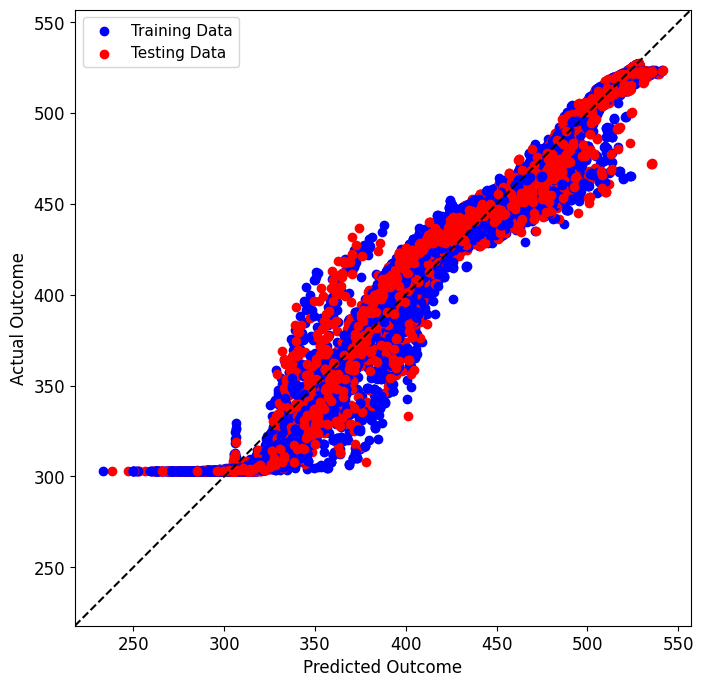

In [10]:
ax = postprocessor.diagonal_validation_plot(model_type='Linear')
plt.show()

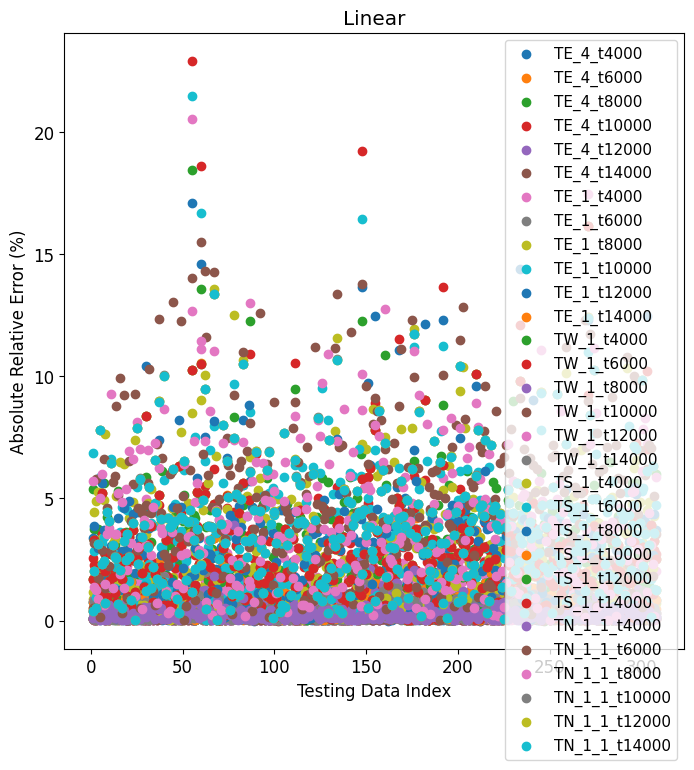

In [11]:
models = ["Linear", "Lasso", "DT", "RF", "KN"]
i = 0
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

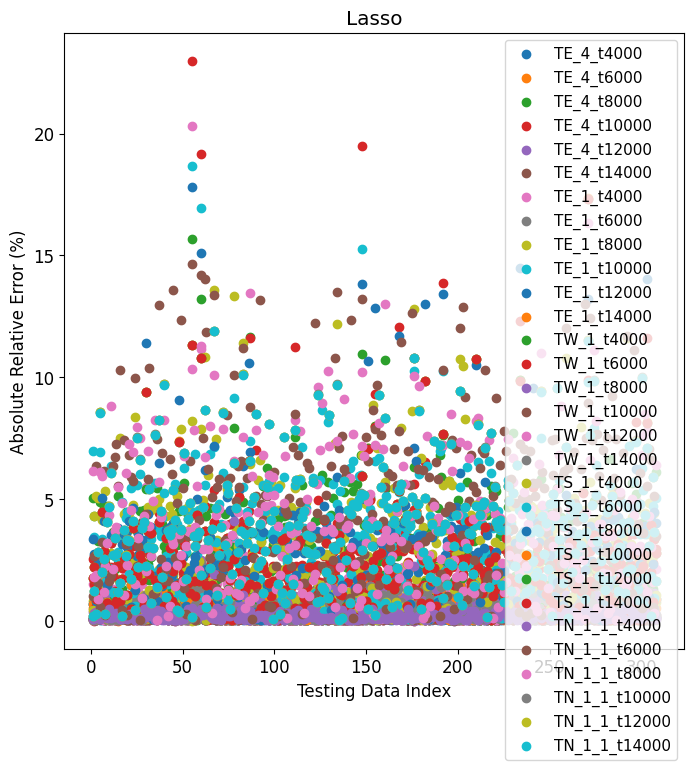

In [12]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

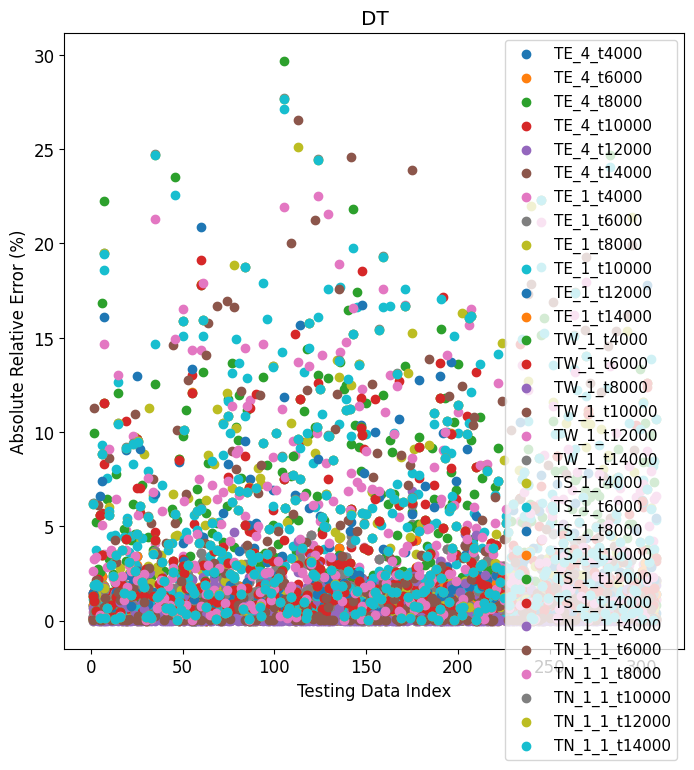

In [13]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

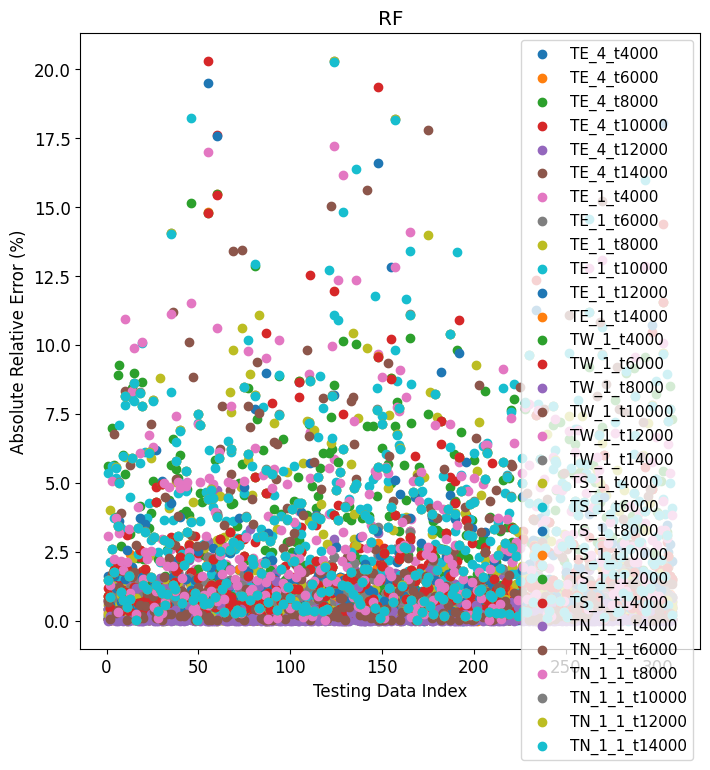

In [14]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

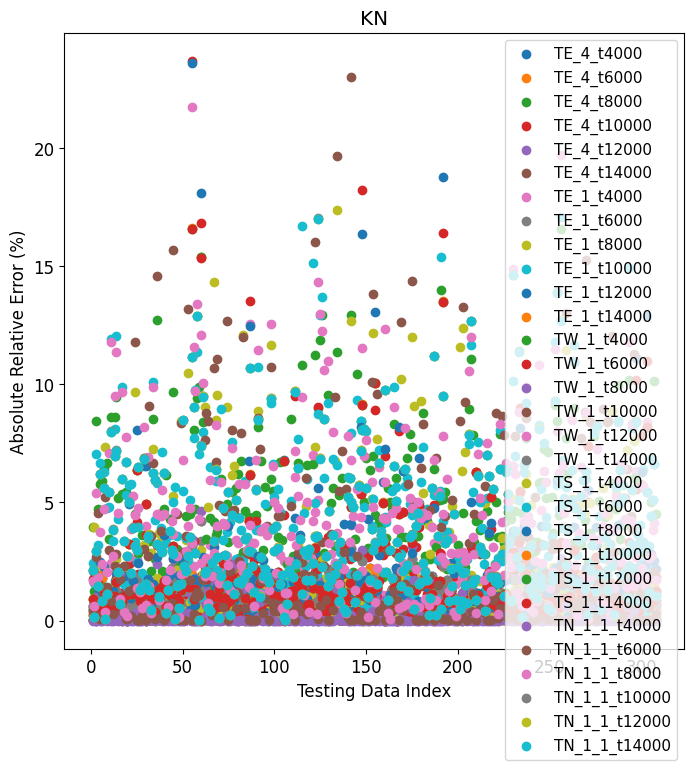

In [15]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

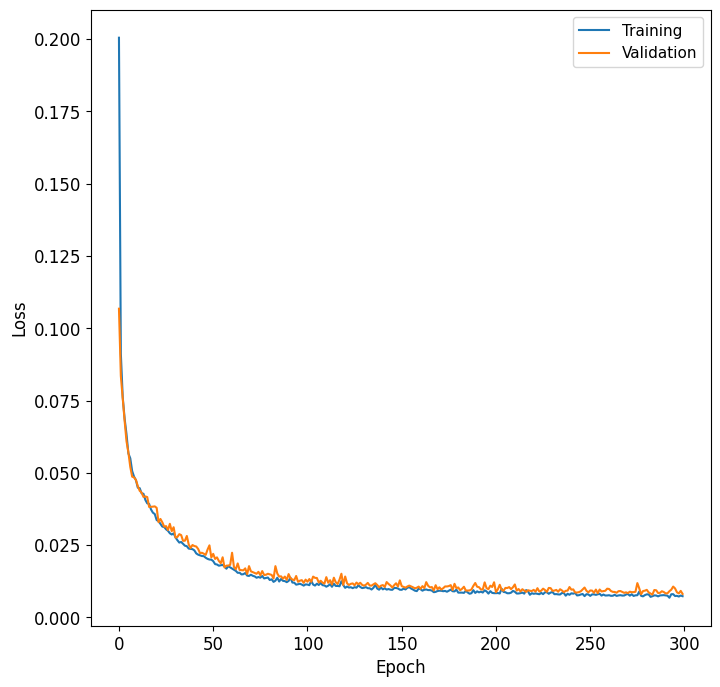

In [16]:
postprocessor.nn_learning_plot()
plt.show()

In [17]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.0008637280699245254

Model Types: DT
max_depth: 27
max_features: None
min_samples_leaf: 5
min_samples_split: 9

Model Types: RF
criterion: squared_error
max_features: None
min_samples_leaf: 3
min_samples_split: 8
n_estimators: 123

Model Types: KN
leaf_size: 13
n_neighbors: 8
p: 2
weights: distance

Model Types: FNN
Dense_input_0_units: 299
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.4144202618356004
Dense_hidden_num_layers: 0
Adam_learning_rate: 0.0007583508942311782
Dense_hidden_0_units: 145
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.44991842369855306
Dense_hidden_1_units: 168
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.5876139293714984
batch_size: 8
Dense_hidden_2_units: 243
Dense_hidden_2_sublayer: Dropout_hidden
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.5385132514063617



<h3> Exercise Set 3

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Sklearn tools
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#Keras specials
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#load the input and output dataframes from github
xdf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_x.csv')
ydf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_y.csv')
xtrain, xtest, ytrain, ytest = train_test_split(xdf.values, ydf.values, random_state=42, test_size=0.2)
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()
Xtrain = xscaler.fit_transform(xtrain)
Xtest = xscaler.transform(xtest)
Ytrain = yscaler.fit_transform(ytrain)
Ytest = yscaler.transform(ytest)

num_dens_layers = 5                     #including the input/first layer
n_nodes=[50, 200, 200, 200, 200]  #node per layer
model = Sequential()
model.add(Input(shape=(Xtrain.shape[1],)))
model.add(Dense(n_nodes[0], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
for i in range(1,num_dens_layers):
    model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu')) #Last layer (use linear activation and set nodes to number of Y columns/labels/outputs
model.add(Dense(Ytrain.shape[1], kernel_initializer='normal',activation='linear'))

model.compile(loss='mean_absolute_error', optimizer=Adam(6e-4), metrics=['mean_absolute_error'])
model.summary()
cp = ModelCheckpoint('best_model_manual_tuning.keras', monitor='val_mean_absolute_error', save_best_only=True, mode='min', verbose=1)
history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=8, validation_split = 0.15, callbacks=cp, verbose=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         6,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,880 (538.59 KB)

 Trainable params: 137,880 (538.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - loss: 0.5598 - mean_absolute_error: 0.5598


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5528 - mean_absolute_error: 0.5528 


56/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4520 - mean_absolute_error: 0.4520


85/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3875 - mean_absolute_error: 0.3875


Epoch 1: val_mean_absolute_error improved from inf to 0.11177, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3823 - mean_absolute_error: 0.3823 - val_loss: 0.1118 - val_mean_absolute_error: 0.1118


Epoch 2/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - loss: 0.1016 - mean_absolute_error: 0.1016


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1147 - mean_absolute_error: 0.1147   


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1137 - mean_absolute_error: 0.1137


84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1128 - mean_absolute_error: 0.1128


Epoch 2: val_mean_absolute_error did not improve from 0.11177



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1127 - mean_absolute_error: 0.1127 - val_loss: 0.1123 - val_mean_absolute_error: 0.1123


Epoch 3/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.1125 - mean_absolute_error: 0.1125


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1119 - mean_absolute_error: 0.1119  


54/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1093 - mean_absolute_error: 0.1093


82/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1086 - mean_absolute_error: 0.1086


Epoch 3: val_mean_absolute_error improved from 0.11177 to 0.09845, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1084 - mean_absolute_error: 0.1084 - val_loss: 0.0985 - val_mean_absolute_error: 0.0985


Epoch 4/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1032 - mean_absolute_error: 0.1032


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1034 - mean_absolute_error: 0.1034 


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1020 - mean_absolute_error: 0.1020


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1023 - mean_absolute_error: 0.1023


Epoch 4: val_mean_absolute_error did not improve from 0.09845



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1023 - mean_absolute_error: 0.1023 - val_loss: 0.1031 - val_mean_absolute_error: 0.1031


Epoch 5/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0936 - mean_absolute_error: 0.0936


30/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0974 - mean_absolute_error: 0.0974  


61/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0981 - mean_absolute_error: 0.0981


Epoch 5: val_mean_absolute_error improved from 0.09845 to 0.09211, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0976 - mean_absolute_error: 0.0976 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921


Epoch 6/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0959 - mean_absolute_error: 0.0959


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0887 - mean_absolute_error: 0.0887 


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0879 - mean_absolute_error: 0.0879


Epoch 6: val_mean_absolute_error improved from 0.09211 to 0.08015, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0873 - mean_absolute_error: 0.0873 - val_loss: 0.0801 - val_mean_absolute_error: 0.0801


Epoch 7/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0770 - mean_absolute_error: 0.0770


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0803 - mean_absolute_error: 0.0803 


54/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0791 - mean_absolute_error: 0.0791


78/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0778 - mean_absolute_error: 0.0778


Epoch 7: val_mean_absolute_error improved from 0.08015 to 0.06058, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0773 - mean_absolute_error: 0.0773 - val_loss: 0.0606 - val_mean_absolute_error: 0.0606


Epoch 8/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0782 - mean_absolute_error: 0.0782


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0657 - mean_absolute_error: 0.0657 


55/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0669 - mean_absolute_error: 0.0669


84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0672 - mean_absolute_error: 0.0672


Epoch 8: val_mean_absolute_error improved from 0.06058 to 0.05892, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0672 - mean_absolute_error: 0.0672 - val_loss: 0.0589 - val_mean_absolute_error: 0.0589


Epoch 9/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0482 - mean_absolute_error: 0.0482


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0554 - mean_absolute_error: 0.0554 


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0571 - mean_absolute_error: 0.0571


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0574 - mean_absolute_error: 0.0574


Epoch 9: val_mean_absolute_error improved from 0.05892 to 0.04696, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0574 - mean_absolute_error: 0.0574 - val_loss: 0.0470 - val_mean_absolute_error: 0.0470


Epoch 10/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0557 - mean_absolute_error: 0.0557


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0570 - mean_absolute_error: 0.0570 


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0558 - mean_absolute_error: 0.0558


Epoch 10: val_mean_absolute_error did not improve from 0.04696



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0554 - mean_absolute_error: 0.0554 - val_loss: 0.0657 - val_mean_absolute_error: 0.0657


Epoch 11/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0457 - mean_absolute_error: 0.0457


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0547 - mean_absolute_error: 0.0547   


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0539 - mean_absolute_error: 0.0539


Epoch 11: val_mean_absolute_error improved from 0.04696 to 0.04382, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - mean_absolute_error: 0.0534 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438


Epoch 12/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0611 - mean_absolute_error: 0.0611


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0541 - mean_absolute_error: 0.0541 


52/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0522 - mean_absolute_error: 0.0522


77/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0509 - mean_absolute_error: 0.0509


Epoch 12: val_mean_absolute_error improved from 0.04382 to 0.04115, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0412 - val_mean_absolute_error: 0.0412


Epoch 13/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0376 - mean_absolute_error: 0.0376


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440 - mean_absolute_error: 0.0440 


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0442 - mean_absolute_error: 0.0442


86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445 - mean_absolute_error: 0.0445


Epoch 13: val_mean_absolute_error did not improve from 0.04115



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445 - mean_absolute_error: 0.0445 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448


Epoch 14/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0397 - mean_absolute_error: 0.0397


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445 - mean_absolute_error: 0.0445  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0442 - mean_absolute_error: 0.0442


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436 - mean_absolute_error: 0.0436


Epoch 14: val_mean_absolute_error did not improve from 0.04115



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436 - mean_absolute_error: 0.0436 - val_loss: 0.0451 - val_mean_absolute_error: 0.0451


Epoch 15/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0342 - mean_absolute_error: 0.0342


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0393 - mean_absolute_error: 0.0393  


60/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0402 - mean_absolute_error: 0.0402


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0407 - mean_absolute_error: 0.0407


Epoch 15: val_mean_absolute_error did not improve from 0.04115



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - val_loss: 0.0712 - val_mean_absolute_error: 0.0712


Epoch 16/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0516 - mean_absolute_error: 0.0516


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411 - mean_absolute_error: 0.0411  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403 - mean_absolute_error: 0.0403


Epoch 16: val_mean_absolute_error improved from 0.04115 to 0.03719, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402 - mean_absolute_error: 0.0402 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372


Epoch 17/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0271 - mean_absolute_error: 0.0271


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - mean_absolute_error: 0.0361


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0370 - mean_absolute_error: 0.0370


Epoch 17: val_mean_absolute_error improved from 0.03719 to 0.03560, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356


Epoch 18/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0358 - mean_absolute_error: 0.0358


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 


54/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0348 - mean_absolute_error: 0.0348


81/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 - mean_absolute_error: 0.0350


Epoch 18: val_mean_absolute_error did not improve from 0.03560



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461


Epoch 19/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0321 - mean_absolute_error: 0.0321


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0351 - mean_absolute_error: 0.0351


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 - mean_absolute_error: 0.0350


Epoch 19: val_mean_absolute_error did not improve from 0.03560



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0501 - val_mean_absolute_error: 0.0501


Epoch 20/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0254 - mean_absolute_error: 0.0254


30/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - mean_absolute_error: 0.0315  


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - mean_absolute_error: 0.0319


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0318 - mean_absolute_error: 0.0318


Epoch 20: val_mean_absolute_error did not improve from 0.03560



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467


Epoch 21/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.0389 - mean_absolute_error: 0.0389


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - mean_absolute_error: 0.0319  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324 - mean_absolute_error: 0.0324


Epoch 21: val_mean_absolute_error improved from 0.03560 to 0.03434, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343


Epoch 22/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0305 - mean_absolute_error: 0.0305


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0294 - mean_absolute_error: 0.0294 


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302 - mean_absolute_error: 0.0302


Epoch 22: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 - mean_absolute_error: 0.0305 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437


Epoch 23/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0274 - mean_absolute_error: 0.0274


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - mean_absolute_error: 0.0295   


51/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293 - mean_absolute_error: 0.0293


79/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 - mean_absolute_error: 0.0291


Epoch 23: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 - mean_absolute_error: 0.0291 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366


Epoch 24/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0342 - mean_absolute_error: 0.0342


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - mean_absolute_error: 0.0284 


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - mean_absolute_error: 0.0292


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - mean_absolute_error: 0.0295


Epoch 24: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - mean_absolute_error: 0.0295 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362


Epoch 25/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0373 - mean_absolute_error: 0.0373


30/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - mean_absolute_error: 0.0306  


60/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 - mean_absolute_error: 0.0301


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - mean_absolute_error: 0.0300


Epoch 25: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0580 - val_mean_absolute_error: 0.0580


Epoch 26/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0305 - mean_absolute_error: 0.0305


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289 - mean_absolute_error: 0.0289  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - mean_absolute_error: 0.0287


Epoch 26: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285 - mean_absolute_error: 0.0285 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453


Epoch 27/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0286 - mean_absolute_error: 0.0286


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289 - mean_absolute_error: 0.0289   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - mean_absolute_error: 0.0283


Epoch 27: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410


Epoch 28/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0218 - mean_absolute_error: 0.0218


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245 - mean_absolute_error: 0.0245   


50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 - mean_absolute_error: 0.0257


76/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 - mean_absolute_error: 0.0259


Epoch 28: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - mean_absolute_error: 0.0260 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376


Epoch 29/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0306 - mean_absolute_error: 0.0306


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - mean_absolute_error: 0.0284 


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - mean_absolute_error: 0.0276


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - mean_absolute_error: 0.0277


Epoch 29: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0607 - val_mean_absolute_error: 0.0607


Epoch 30/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0352 - mean_absolute_error: 0.0352


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 - mean_absolute_error: 0.0352  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - mean_absolute_error: 0.0330


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - mean_absolute_error: 0.0315


Epoch 30: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0574 - val_mean_absolute_error: 0.0574


Epoch 31/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0245 - mean_absolute_error: 0.0245


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0278 - mean_absolute_error: 0.0278  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285 - mean_absolute_error: 0.0285


Epoch 31: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - mean_absolute_error: 0.0282 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512


Epoch 32/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0359 - mean_absolute_error: 0.0359


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273 - mean_absolute_error: 0.0273   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270 - mean_absolute_error: 0.0270


Epoch 32: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521


Epoch 33/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0194 - mean_absolute_error: 0.0194


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.0222   


49/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - mean_absolute_error: 0.0229


73/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - mean_absolute_error: 0.0231


Epoch 33: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - mean_absolute_error: 0.0233 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458


Epoch 34/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0234 - mean_absolute_error: 0.0234


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243 - mean_absolute_error: 0.0243 


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - mean_absolute_error: 0.0241


86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.0240


Epoch 34: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0404 - val_mean_absolute_error: 0.0404


Epoch 35/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.0222 - mean_absolute_error: 0.0222


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243 - mean_absolute_error: 0.0243  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.0240


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.0240


Epoch 35: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423


Epoch 36/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0207 - mean_absolute_error: 0.0207


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - mean_absolute_error: 0.0235  


60/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245 - mean_absolute_error: 0.0245


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - mean_absolute_error: 0.0246


Epoch 36: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0424 - val_mean_absolute_error: 0.0424


Epoch 37/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0238 - mean_absolute_error: 0.0238


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234 - mean_absolute_error: 0.0234  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236 - mean_absolute_error: 0.0236


Epoch 37: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.0631 - val_mean_absolute_error: 0.0631


Epoch 38/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0205 - mean_absolute_error: 0.0205


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.0240   


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - mean_absolute_error: 0.0237


Epoch 38: val_mean_absolute_error did not improve from 0.03434



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.0389 - val_mean_absolute_error: 0.0389


Epoch 39/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 0.0199 - mean_absolute_error: 0.0199


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - mean_absolute_error: 0.0212  


55/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mean_absolute_error: 0.0218


84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.0222


Epoch 39: val_mean_absolute_error improved from 0.03434 to 0.03374, saving model to best_model_manual_tuning.keras



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337


Epoch 40/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0227 - mean_absolute_error: 0.0227


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223 - mean_absolute_error: 0.0223 


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.0222


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.0222


Epoch 40: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0507 - val_mean_absolute_error: 0.0507


Epoch 41/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.0219 - mean_absolute_error: 0.0219


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.0228  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234 - mean_absolute_error: 0.0234


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mean_absolute_error: 0.0232


Epoch 41: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439


Epoch 42/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0200 - mean_absolute_error: 0.0200


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.0222  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - mean_absolute_error: 0.0216


Epoch 42: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339


Epoch 43/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0254 - mean_absolute_error: 0.0254


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - mean_absolute_error: 0.0260   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245 - mean_absolute_error: 0.0245


Epoch 43: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239 - mean_absolute_error: 0.0239 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445


Epoch 44/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0193 - mean_absolute_error: 0.0193


26/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mean_absolute_error: 0.0196   


50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mean_absolute_error: 0.0196


74/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mean_absolute_error: 0.0199


Epoch 44: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0566 - val_mean_absolute_error: 0.0566


Epoch 45/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0239 - mean_absolute_error: 0.0239


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mean_absolute_error: 0.0218 


55/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - mean_absolute_error: 0.0224


84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mean_absolute_error: 0.0227


Epoch 45: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410


Epoch 46/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.0200 - mean_absolute_error: 0.0200


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - mean_absolute_error: 0.0215  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - mean_absolute_error: 0.0219


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - mean_absolute_error: 0.0226


Epoch 46: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0642 - val_mean_absolute_error: 0.0642


Epoch 47/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.0293 - mean_absolute_error: 0.0293


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 - mean_absolute_error: 0.0252  


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247 - mean_absolute_error: 0.0247


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - mean_absolute_error: 0.0244


Epoch 47: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - mean_absolute_error: 0.0244 - val_loss: 0.0494 - val_mean_absolute_error: 0.0494


Epoch 48/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0203 - mean_absolute_error: 0.0203


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - mean_absolute_error: 0.0230  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mean_absolute_error: 0.0232


Epoch 48: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0596 - val_mean_absolute_error: 0.0596


Epoch 49/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0259 - mean_absolute_error: 0.0259


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - mean_absolute_error: 0.0211   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.0204


Epoch 49: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512


Epoch 50/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0259 - mean_absolute_error: 0.0259


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256 - mean_absolute_error: 0.0256   


50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - mean_absolute_error: 0.0244


77/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - mean_absolute_error: 0.0237


Epoch 50: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - mean_absolute_error: 0.0235 - val_loss: 0.0581 - val_mean_absolute_error: 0.0581


Epoch 51/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0202 - mean_absolute_error: 0.0202


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mean_absolute_error: 0.0199 


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.0193


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - mean_absolute_error: 0.0194


Epoch 51: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - mean_absolute_error: 0.0194 - val_loss: 0.0511 - val_mean_absolute_error: 0.0511


Epoch 52/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0181 - mean_absolute_error: 0.0181


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mean_absolute_error: 0.0232  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - mean_absolute_error: 0.0231


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.0228


Epoch 52: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0446 - val_mean_absolute_error: 0.0446


Epoch 53/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0189 - mean_absolute_error: 0.0189


30/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - mean_absolute_error: 0.0221  


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mean_absolute_error: 0.0218


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mean_absolute_error: 0.0217


Epoch 53: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0503 - val_mean_absolute_error: 0.0503


Epoch 54/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0155 - mean_absolute_error: 0.0155


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mean_absolute_error: 0.0202  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - mean_absolute_error: 0.0213


Epoch 54: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512


Epoch 55/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0163 - mean_absolute_error: 0.0163


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mean_absolute_error: 0.0190   


61/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mean_absolute_error: 0.0192


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mean_absolute_error: 0.0192


Epoch 55: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483


Epoch 56/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0152 - mean_absolute_error: 0.0152


26/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mean_absolute_error: 0.0192  


50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mean_absolute_error: 0.0190


77/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mean_absolute_error: 0.0190


Epoch 56: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mean_absolute_error: 0.0190 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371


Epoch 57/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 0.0232 - mean_absolute_error: 0.0232


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.0198


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - mean_absolute_error: 0.0197


Epoch 57: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - mean_absolute_error: 0.0197 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390


Epoch 58/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0223 - mean_absolute_error: 0.0223


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - mean_absolute_error: 0.0206  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - mean_absolute_error: 0.0209


Epoch 58: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376


Epoch 59/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0231 - mean_absolute_error: 0.0231


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - mean_absolute_error: 0.0203   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - mean_absolute_error: 0.0194


Epoch 59: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0536 - val_mean_absolute_error: 0.0536


Epoch 60/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0175 - mean_absolute_error: 0.0175


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mean_absolute_error: 0.0173   


49/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.0176


74/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0181


Epoch 60: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183 - mean_absolute_error: 0.0183 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357


Epoch 61/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0254 - mean_absolute_error: 0.0254


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - mean_absolute_error: 0.0213 


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.0204


86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mean_absolute_error: 0.0199


Epoch 61: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0435 - val_mean_absolute_error: 0.0435


Epoch 62/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0154 - mean_absolute_error: 0.0154


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0181  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.0182


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - mean_absolute_error: 0.0183


Epoch 62: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - mean_absolute_error: 0.0183 - val_loss: 0.0516 - val_mean_absolute_error: 0.0516


Epoch 63/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0152 - mean_absolute_error: 0.0152


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0181  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.0189


Epoch 63: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0188 - val_loss: 0.0516 - val_mean_absolute_error: 0.0516


Epoch 64/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0139 - mean_absolute_error: 0.0139


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mean_absolute_error: 0.0190   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mean_absolute_error: 0.0202


Epoch 64: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510


Epoch 65/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0206 - mean_absolute_error: 0.0206


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.0179   


50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.0182


76/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.0185


Epoch 65: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - mean_absolute_error: 0.0186 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422


Epoch 66/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0153 - mean_absolute_error: 0.0153


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0174 


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.0176


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.0177


Epoch 66: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.0177 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447


Epoch 67/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0155 - mean_absolute_error: 0.0155


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.0177  


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - mean_absolute_error: 0.0186


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0188


Epoch 67: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0188 - val_loss: 0.0547 - val_mean_absolute_error: 0.0547


Epoch 68/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0145 - mean_absolute_error: 0.0145


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201 - mean_absolute_error: 0.0201  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - mean_absolute_error: 0.0208


Epoch 68: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0552 - val_mean_absolute_error: 0.0552


Epoch 69/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0197 - mean_absolute_error: 0.0197


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0181   


61/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.0182


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mean_absolute_error: 0.0180


Epoch 69: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450


Epoch 70/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0173 - mean_absolute_error: 0.0173


26/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mean_absolute_error: 0.0171  


52/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170


80/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169


Epoch 70: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0478 - val_mean_absolute_error: 0.0478


Epoch 71/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.0148 - mean_absolute_error: 0.0148


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - mean_absolute_error: 0.0178 


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.0179


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mean_absolute_error: 0.0180


Epoch 71: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0.0505 - val_mean_absolute_error: 0.0505


Epoch 72/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0204 - mean_absolute_error: 0.0204


30/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - mean_absolute_error: 0.0197  


61/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - mean_absolute_error: 0.0197


Epoch 72: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.0198 - val_loss: 0.0459 - val_mean_absolute_error: 0.0459


Epoch 73/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0179 - mean_absolute_error: 0.0179


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.0200   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mean_absolute_error: 0.0196


Epoch 73: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - mean_absolute_error: 0.0194 - val_loss: 0.0494 - val_mean_absolute_error: 0.0494


Epoch 74/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0158 - mean_absolute_error: 0.0158


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.0176   


53/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mean_absolute_error: 0.0180


77/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - mean_absolute_error: 0.0184


Epoch 74: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360


Epoch 75/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0192 - mean_absolute_error: 0.0192


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.0198 


55/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.0200


84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.0198


Epoch 75: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.0198 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381


Epoch 76/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0148 - mean_absolute_error: 0.0148


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - mean_absolute_error: 0.0194  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - mean_absolute_error: 0.0195


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - mean_absolute_error: 0.0195


Epoch 76: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - mean_absolute_error: 0.0195 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508


Epoch 77/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0209 - mean_absolute_error: 0.0209


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170


Epoch 77: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438


Epoch 78/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0159 - mean_absolute_error: 0.0159


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mean_absolute_error: 0.0173


Epoch 78: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0478 - val_mean_absolute_error: 0.0478


Epoch 79/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0142 - mean_absolute_error: 0.0142


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201 - mean_absolute_error: 0.0201   


49/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mean_absolute_error: 0.0192


74/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mean_absolute_error: 0.0187


Epoch 79: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - val_loss: 0.0650 - val_mean_absolute_error: 0.0650


Epoch 80/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0226 - mean_absolute_error: 0.0226


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - mean_absolute_error: 0.0186 


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.0177


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175


Epoch 80: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0488 - val_mean_absolute_error: 0.0488


Epoch 81/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0182 - mean_absolute_error: 0.0182


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.0193  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mean_absolute_error: 0.0187


Epoch 81: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - mean_absolute_error: 0.0184 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572


Epoch 82/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0165 - mean_absolute_error: 0.0165


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.0177  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0174


Epoch 82: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465


Epoch 83/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0190 - mean_absolute_error: 0.0190


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.0179   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0181


Epoch 83: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448


Epoch 84/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0112 - mean_absolute_error: 0.0112


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mean_absolute_error: 0.0150   


50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mean_absolute_error: 0.0158


76/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0162


Epoch 84: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0442 - val_mean_absolute_error: 0.0442


Epoch 85/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0147 - mean_absolute_error: 0.0147


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mean_absolute_error: 0.0164 


57/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175


Epoch 85: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.0176 - val_loss: 0.0600 - val_mean_absolute_error: 0.0600


Epoch 86/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0213 - mean_absolute_error: 0.0213


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0172  


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169


Epoch 86: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455


Epoch 87/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0170 - mean_absolute_error: 0.0170


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.0185  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mean_absolute_error: 0.0187


Epoch 87: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - mean_absolute_error: 0.0184 - val_loss: 0.0386 - val_mean_absolute_error: 0.0386


Epoch 88/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0179 - mean_absolute_error: 0.0179


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mean_absolute_error: 0.0173   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mean_absolute_error: 0.0173


Epoch 88: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450


Epoch 89/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0137 - mean_absolute_error: 0.0137


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169   


51/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0172


77/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0172


Epoch 89: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mean_absolute_error: 0.0173 - val_loss: 0.0566 - val_mean_absolute_error: 0.0566


Epoch 90/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0164 - mean_absolute_error: 0.0164


28/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0172 


58/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - mean_absolute_error: 0.0178


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.0179


Epoch 90: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0553 - val_mean_absolute_error: 0.0553


Epoch 91/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0194 - mean_absolute_error: 0.0194


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mean_absolute_error: 0.0173


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175


Epoch 91: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0429 - val_mean_absolute_error: 0.0429


Epoch 92/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0230 - mean_absolute_error: 0.0230


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.0204  


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - mean_absolute_error: 0.0197


Epoch 92: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0488 - val_mean_absolute_error: 0.0488


Epoch 93/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0197 - mean_absolute_error: 0.0197


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170   


41/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - mean_absolute_error: 0.0171


65/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mean_absolute_error: 0.0170


Epoch 93: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379


Epoch 94/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0172 - mean_absolute_error: 0.0172


30/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mean_absolute_error: 0.0171 


55/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mean_absolute_error: 0.0166


79/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mean_absolute_error: 0.0164


Epoch 94: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0515 - val_mean_absolute_error: 0.0515


Epoch 95/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0157 - mean_absolute_error: 0.0157


27/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - mean_absolute_error: 0.0156 


55/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mean_absolute_error: 0.0160


84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mean_absolute_error: 0.0161


Epoch 95: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0457 - val_mean_absolute_error: 0.0457


Epoch 96/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0170 - mean_absolute_error: 0.0170


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mean_absolute_error: 0.0165  


59/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mean_absolute_error: 0.0171


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0174


Epoch 96: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0511 - val_mean_absolute_error: 0.0511


Epoch 97/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0159 - mean_absolute_error: 0.0159


29/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0155  


60/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mean_absolute_error: 0.0166


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169


Epoch 97: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0492 - val_mean_absolute_error: 0.0492


Epoch 98/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0161 - mean_absolute_error: 0.0161


32/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0155  


63/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0154


Epoch 98: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - mean_absolute_error: 0.0156 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483


Epoch 99/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0200 - mean_absolute_error: 0.0200


31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mean_absolute_error: 0.0169   


62/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mean_absolute_error: 0.0164


Epoch 99: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0553 - val_mean_absolute_error: 0.0553


Epoch 100/100



 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0148 - mean_absolute_error: 0.0148


25/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.0172   


50/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mean_absolute_error: 0.0174


76/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175


Epoch 100: val_mean_absolute_error did not improve from 0.03374



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0432 - val_mean_absolute_error: 0.0432


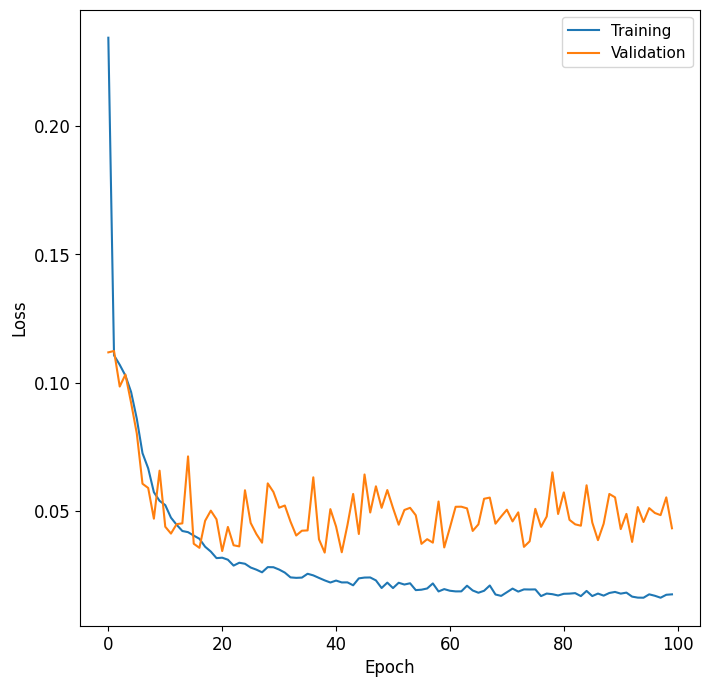

In [19]:
train_err=history.history['mean_absolute_error']
val_err=history.history['val_mean_absolute_error']
plt.figure()
plt.plot(train_err, label='Training')
plt.plot(val_err, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [20]:
# Baseline predictions using XTest
model = load_model('best_model_manual_tuning.keras')
pred_0 = model.predict(Xtest)
preds = []
# Get predictions with a feature randomized
for i in range(20):
    Xtest_rand = Xtest
    Xtest_rand[:,i] = np.random.uniform(0, 1, size=Xtest_rand.shape[0])
    preds.append(model.predict(Xtest_rand))


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [21]:
# Array is shape (20, 819, 30) (feature randomized, sim #, output)
maes = []
preds_array = np.stack(preds)
reference_mae = mean_absolute_error(Ytest[:,0], pred_0[:,0])

# TE_4_t4000 Feature Importances correspond to (:,:,0)
for i in range(preds_array.shape[0]):
    # Find MAE with randomized feature - MAE with no feature randomized
    maes.append(mean_absolute_error(Ytest[:,0], preds_array[i,:,0]) - reference_mae) 
# Add change in MAE due to randomizations (aka feature importances) to DF and sort
out1_df = pd.DataFrame(np.stack(maes), columns=['Feature Importance'], index=xdf.columns, dtype=float)
out1_df_sorted = out1_df.sort_values(by='Feature Importance', key=abs, ascending=False)

maes = []
reference_mae = mean_absolute_error(Ytest[:,14], pred_0[:,14])
# TW_1_t8000 Feature Importances correspond to (:,:,14)
for i in range(preds_array.shape[0]):
    maes.append(mean_absolute_error(Ytest[:,14], preds_array[i,:,14]) - reference_mae) 
out2_df = pd.DataFrame(np.stack(maes), columns=['Feature Importance'], index=xdf.columns, dtype=float)
out2_df_sorted = out2_df.sort_values(by='Feature Importance', key=abs, ascending=False)

maes = []
reference_mae = mean_absolute_error(Ytest[:,24], pred_0[:,24])
# TN_1_1_t4000 Feature Importances correspond to (:,:,24)
for i in range(preds_array.shape[0]):
    maes.append(mean_absolute_error(Ytest[:,24], preds_array[i,:,24]) - reference_mae) 
out3_df = pd.DataFrame(np.stack(maes), columns=['Feature Importance'], index=xdf.columns, dtype=float)
out3_df_sorted = out3_df.sort_values(by='Feature Importance', key=abs, ascending=False)


Text(0.5, 1.0, 'Feature Importance on TN_1_1_t4000')

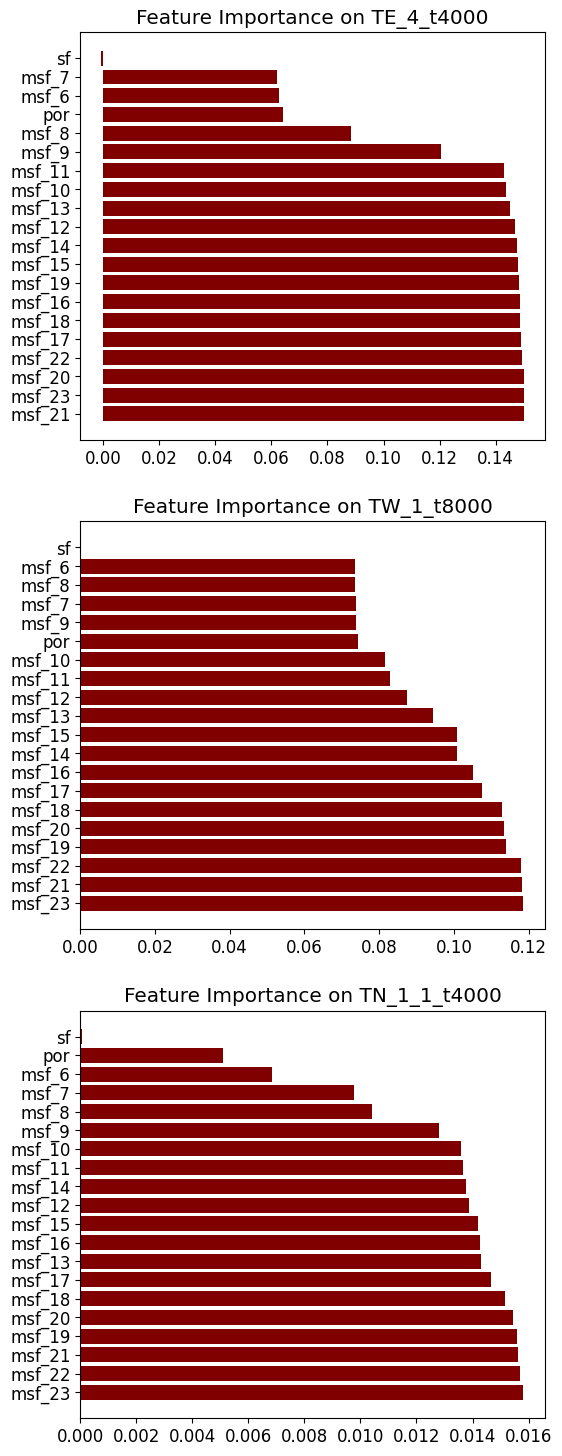

In [22]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(6,18)
ax[0].barh(out1_df_sorted.index.array, out1_df_sorted['Feature Importance'].values, color='maroon')
ax[0].set_title('Feature Importance on TE_4_t4000')
ax[1].barh(out2_df_sorted.index.array, out2_df_sorted['Feature Importance'].values, color='maroon')
ax[1].set_title('Feature Importance on TW_1_t8000')
ax[2].barh(out3_df_sorted.index.array, out3_df_sorted['Feature Importance'].values, color='maroon')
ax[2].set_title('Feature Importance on TN_1_1_t4000')

Here, feature importance represents the change in MAE due to the randomization of a paticular input. For all 3 outputs, sf was the least important feature. msf_20 through msf_23 were always important features for all outputs. And overall, TN_1_1_t4000 was the most robust to randomizations of features, although this is likely because its MAE was high to begin with.